# Tutorial for Analyzing Node Performance [![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/waggle-sensor/edge-scheduler/blob/main/scripts/analysis/analyze_node_performance.ipynb)
This shows how to pull performance data of a Waggle node. This will help system and application designers to understand how the edge computing nodes work for applications running on them.

## Install Dependent Packages
The sage_data_client Python package needs to be installed to query data from the Waggle data repository

__NOTE: Newer pip will ask you to put the `--break-system-packages` option in the install command. If you do not want to do so, please follow their guidance that will appear in the terminal after running the command WITHOUT the option.__

In [1]:
!pip3 install sage_data_client matplotlib --break-system-packages


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.12 -m pip install --upgrade pip


## Pull and Plot CPU Utilization of A Waggle Node
We will pull CPU utilization of a Waggle node, named `W023`, from the repository. First, we import the libraries,

__NOTE: This feature of performance measurement is under active development. Once it is released in the production of Waggle nodes, you will be able to pull the data from any node. In this tutorial we select the node W023 as it is one of the test nodes publishing the data.__

In [2]:
from sage_data_client import query
import matplotlib.pyplot as plt

In [3]:
# We take the measurements in the last hour
since = "-1h"

# Query data for CPU utilization
df_cpu = query(
    bucket="grafana-agent", # the performance data are stored in this bucket
    start=since,
    filter={
        "name": "tegra_cpu_util_percentage", # The name of the metric
        "vsn": "W023",                       # The name of the Waggle node
    },
)

# Query data for GPU utilization
df_gpu = query(
    bucket="grafana-agent", # the performance data are stored in this bucket
    start=since,
    filter={
        "name": "tegra_gpu_util_percentage", # The name of the metric
        "vsn": "W023",                       # The name of the Waggle node
    },
)

# Query data for power consumption of the system
df_power = query(
    bucket="grafana-agent",
    start=since,
    filter={
        "name": "tegra_wattage_current_milliwatts",
        "vsn": "W023",
    },
)

The data looks like,

In [4]:
df_cpu.head()

,timestamp,name,value,meta.cluster,meta.container,meta.cpu,meta.endpoint,meta.host,meta.hostname,meta.instance,meta.job,meta.metrics_path,meta.namespace,meta.pod,meta.vsn
0,2024-09-19 02:57:14.608000+00:00,tegra_cpu_util_percentage,13,default/grafana-agent,jetson-exporter,1,9101,beehive-grafana-agent-loader-64fccdc84b-6hnl5,000048b02d15bc7c.ws-nxcore,10.42.0.52:9101,integrations/kubernetes/pod,/metrics,default,wes-jetson-exporter-n5clj,W023
1,2024-09-19 02:57:29.608000+00:00,tegra_cpu_util_percentage,7,default/grafana-agent,jetson-exporter,1,9101,beehive-grafana-agent-loader-64fccdc84b-6hnl5,000048b02d15bc7c.ws-nxcore,10.42.0.52:9101,integrations/kubernetes/pod,/metrics,default,wes-jetson-exporter-n5clj,W023
2,2024-09-19 02:57:44.608000+00:00,tegra_cpu_util_percentage,13,default/grafana-agent,jetson-exporter,1,9101,beehive-grafana-agent-loader-64fccdc84b-6hnl5,000048b02d15bc7c.ws-nxcore,10.42.0.52:9101,integrations/kubernetes/pod,/metrics,default,wes-jetson-exporter-n5clj,W023
3,2024-09-19 02:57:59.608000+00:00,tegra_cpu_util_percentage,17,default/grafana-agent,jetson-exporter,1,9101,beehive-grafana-agent-loader-64fccdc84b-6hnl5,000048b02d15bc7c.ws-nxcore,10.42.0.52:9101,integrations/kubernetes/pod,/metrics,default,wes-jetson-exporter-n5clj,W023
4,2024-09-19 02:58:14.608000+00:00,tegra_cpu_util_percentage,12,default/grafana-agent,jetson-exporter,1,9101,beehive-grafana-agent-loader-64fccdc84b-6hnl5,000048b02d15bc7c.ws-nxcore,10.42.0.52:9101,integrations/kubernetes/pod,/metrics,default,wes-jetson-exporter-n5clj,W023


The wattage values are measured from 3 different sensors in the device,

In [5]:
print(f'The Sensors measuring power consumption on a Nvidia Jetson are {list(df_power["meta.sensor"].unique())}')

The Sensors measuring power consumption on a Nvidia Jetson are ['vdd_cpu_gpu_cv', 'vdd_in', 'vdd_soc']


Let's plot the CPU utilization along with the power consumptions,

Text(0.5, 1.0, 'Power consumption of CPU/GPU of the device')

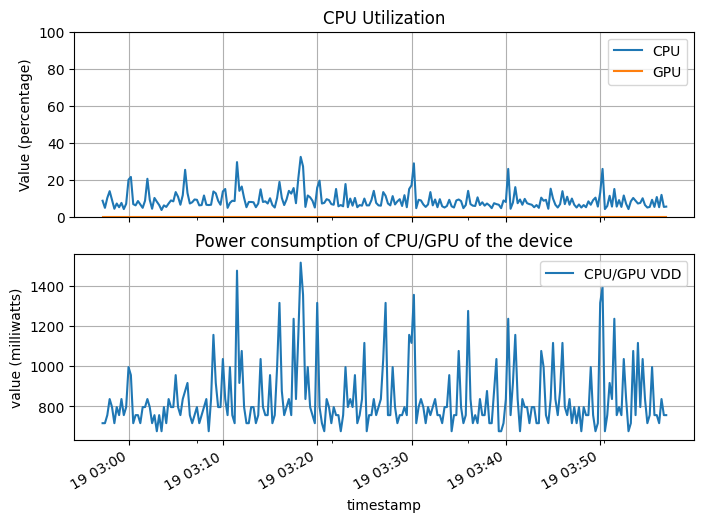

In [6]:
fig, ax = plt.subplots(2, figsize=(8,6), sharex=True)

# tegra_cpu_utilization_percentage shows CPU utilization per logical core in the Waggle node.
# We take the averaged CPU/GPU utilization of all the cores to show the overall utilization.
df_cpu.groupby("timestamp")["value"].mean().reset_index().plot(ax=ax[0], x="timestamp", y="value", label="CPU")
df_gpu.groupby("timestamp")["value"].mean().reset_index().plot(ax=ax[0], x="timestamp", y="value", label="GPU")
ax[0].grid()
ax[0].set_ylim([0, 100])
ax[0].set_ylabel("Value (percentage)")
ax[0].set_title("CPU Utilization")

df_power[df_power["meta.sensor"] == "vdd_cpu_gpu_cv"][["timestamp", "value"]].plot(ax=ax[1], x="timestamp", y="value", label="CPU/GPU VDD")
ax[1].grid()
ax[1].set_ylabel("value (milliwatts)")
ax[1].set_title("Power consumption of CPU/GPU of the device")

You can see that the patterns from the two figures are well aligned, which is true because higher CPU utilization consumes more power.

> Note that the GPU utilization may appear 0 while the power consumption peaks. That is probably because the AI applications running on the node uses GPU for very short period of time (milliseconds) and the measurement interval cannot capture it well, while the power measurement does capture it because the power consumption values stays much longer than how long GPU utilization peaks last.